In [1]:
# Import Libraries
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.linear_model import LogisticRegression as LR
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier as NN
from sklearn.preprocessing import StandardScaler
import warnings

%matplotlib inline

In [2]:
df = pd.read_csv('Apply_Rate_2019.csv')

In [3]:
# classes in Train
class0 = df[(df['apply'] == 0)]
class1 = df[(df['apply'] == 1)]

Y = df['apply']
X = df.drop('apply', axis=1)

[Text(0,0,'Not Apply'), Text(0,0,'Apply')]

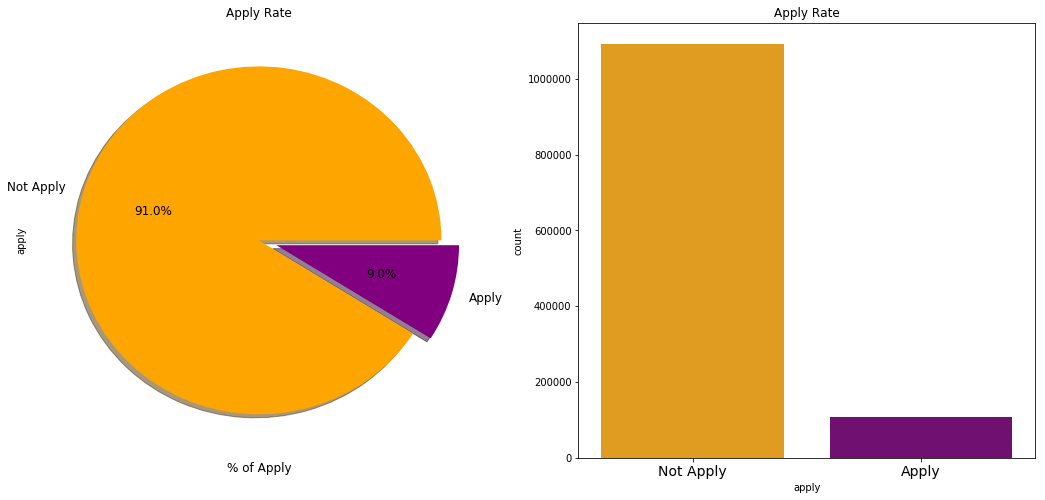

In [4]:
# Data Visualization - Pie-Plot `
f,ax=plt.subplots(1,2,figsize=(18,8))
colors=["orange", "purple"]
labels = 'Not Apply', 'Apply'
ax[0].set_title('Apply Rate', fontsize=12)
ax[0].set_xlabel('% of Apply', fontsize=12)
Y.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=colors, labels=labels,fontsize=12)

# Count Plot for Class-Labels   
sns.countplot(x=Y, data=X, palette=colors, ax=ax[1])
ax[1].set_title('Apply Rate', fontsize=12)
ax[1].set_xticklabels(['Not Apply', 'Apply'], fontsize=14)

### Initial Data Cleanup: Deleting Duplicate Rows from the data and Removing Conflicting Data
Firsty, duplicate data is of no use, so we need to remove it. Then, data having exactly same features, but different labels, would only confuse the model, hence I am removing the same data rows having label 0 and keeping the same data rows having label 1. To do this, I first sort the entire data by 'apply', then drop duplicates, keeping the 'last' i.e 1. So, for example if we have three rows A B 0 A B 1 and A B 1 then only last A B 1 stays in the data.



In [5]:
df = df.sort_values(by=['apply'])

In [6]:
df = df.drop_duplicates(subset=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'city_match',
       'job_age_days', 'search_date_pacific', 'class_id'], keep='last')


In [7]:
df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,class_id
count,818370.000000,818370.000000,1.015138e+06,1.015138e+06,1.015138e+06,795562.000000,1.015138e+06,1.015138e+06,1.015138e+06
mean,5.803646,0.097666,1.809905e+00,1.685765e-02,3.469258e-02,0.557432,1.045177e+01,9.816793e-02,-4.074772e+17
std,9.673044,0.285508,2.243628e+00,1.200526e-02,4.743503e-02,0.496691,1.779251e+01,2.975417e-01,5.653992e+18
min,0.000000,0.000000,0.000000e+00,1.000000e-06,9.998021e-07,0.000000,0.000000e+00,0.000000e+00,-9.049388e+18
25%,0.000000,0.000000,0.000000e+00,1.043647e-02,1.220224e-02,0.000000,2.000000e+00,0.000000e+00,-4.593390e+18
50%,0.000000,0.000000,5.622330e-01,1.562500e-02,2.000000e-02,1.000000,6.000000e+00,0.000000e+00,-1.614083e+18
75%,11.413541,0.065900,3.464677e+00,2.040816e-02,3.655096e-02,1.000000,1.500000e+01,0.000000e+00,4.315422e+18
max,93.516720,7.301161,1.774189e+01,2.556893e-01,1.294088e+00,1.000000,1.340000e+03,1.000000e+00,9.204124e+18


### Feature Engineering and Removing Redundant Features
I drop 'city_match' Column. 
Further, I implement binning to convert the job_age_days into 7 feature columns having binary data and study the correlation of the features with 'apply'. This is because better correlation is observed at categorical level than numerical.

Text(0.5,1,'Boxplot of City_Match')

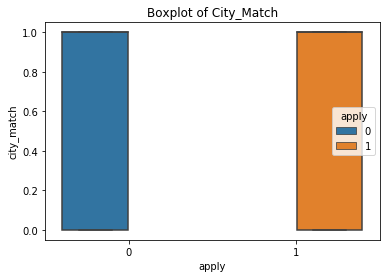

In [8]:
# Data Visualization - BoxPlots
sns.boxplot(data=df, hue='apply', y='city_match', x='apply')
plt.title('Boxplot of City_Match')

### SInce the distrbution of City_match is almost equal for both the classes, this feature won't add any new information to our classifier. Hence, dropping it.

In [9]:
df = df.drop(['city_match'], axis = 1)

In [10]:
# feature engineering of job_age_days

df['today'] = df.apply(lambda row: 1 * (row['job_age_days'] == 0), axis=1)
df['within_a_day'] = df.apply(lambda row: 1 * (row['job_age_days'] == 1), axis=1)
df['within_two_days'] = df.apply(lambda row: 1 * (row['job_age_days'] == 2), axis=1)
df['within_a_week'] = df.apply(lambda row: 1 * (2 < row['job_age_days'] <= 7), axis=1)
df['within_a_month'] = df.apply(lambda row: 1 * (7 < row['job_age_days'] <= 30), axis=1)
df['within_a_year'] = df.apply(lambda row: 1 * (30 < row['job_age_days'] <= 365), axis=1)
df['more_than_a_year'] = df.apply(lambda row: 1 * (row['job_age_days'] > 365), axis=1)

In [11]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,search_date_pacific,class_id,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
0,0.0,0.0,0.000000,0.004824,0.006628,5.0,0,2018-01-21,-7613806991329176388,0,0,0,1,0,0,0
781634,0.0,0.0,2.055071,0.000001,0.000001,13.0,0,2018-01-26,-4832316967726681842,0,0,0,0,1,0,0
781636,NaN,NaN,0.000000,0.018824,0.020905,7.0,0,2018-01-23,2666095119806832141,0,0,0,1,0,0,0
781639,0.0,0.0,2.004822,0.010279,0.010526,0.0,0,2018-01-27,-7706973126229505444,1,0,0,0,0,0,0
781642,0.0,0.0,2.953156,0.000001,0.000001,3.0,0,2018-01-25,-7867367934152049683,0,0,0,1,0,0,0


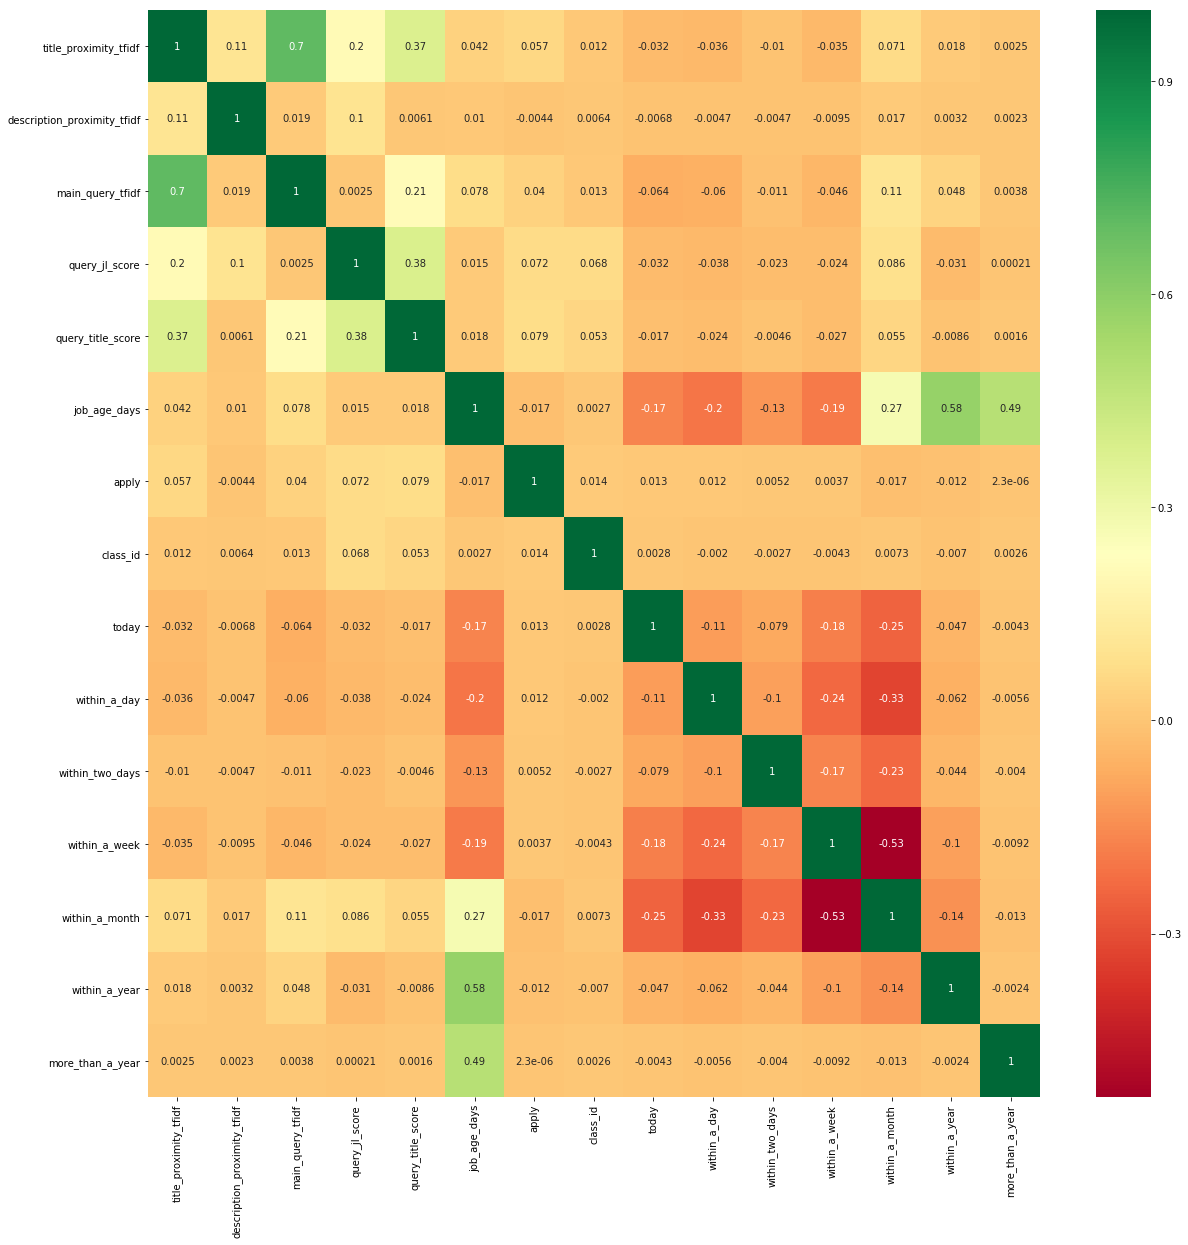

In [12]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

### I found that the features having a substantial magnitude of correlation with ‘apply’ were:
#### i. main_query_tfidf – 0.038
#### ii.	query_jl_score – 0.068
#### iii. query_title_score – 0.074
#### iv.	title_proximity_tfidf - 0.058

#### Whereas, within_a_month and within_a_month had negative correlation which is intuitive since as the job age increases than a month, usually there are no applications on the job.

Displaying Boxplot of the Feature Variables


Text(0.5,1,'Boxplot of Query_JL_Score')

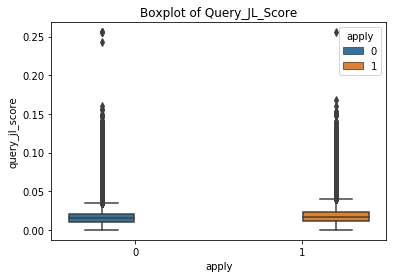

In [13]:
# Data Visualization - BoxPlots
print('Displaying Boxplot of the Feature Variables')
sns.boxplot(data=df, hue='apply', y='query_jl_score', x='apply')
plt.title('Boxplot of Query_JL_Score')

Text(0.5,1,'Boxplot of Query_title_Score')

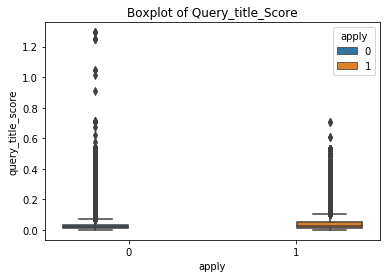

In [14]:
# Data Visualization - BoxPlots
sns.boxplot(data=df, hue='apply', y='query_title_score', x='apply')
plt.title('Boxplot of Query_title_Score')

Text(0.5,1,'Boxplot of description_proximity_tfidf')

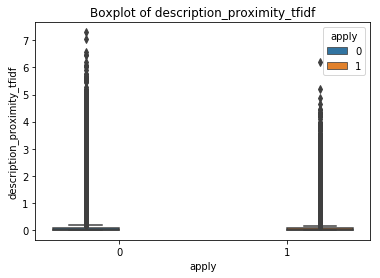

In [15]:
# Data Visualization - BoxPlots
sns.boxplot(data=df, hue='apply', y='description_proximity_tfidf', x='apply')
plt.title('Boxplot of description_proximity_tfidf')

Text(0.5,1,'Boxplot of main_query_tfidf')

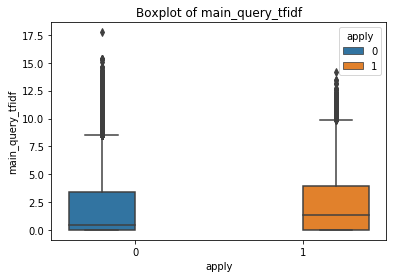

In [16]:
# Data Visualization - BoxPlots
sns.boxplot(data=df, hue='apply', y='main_query_tfidf', x='apply')
plt.title('Boxplot of main_query_tfidf')

Text(0.5,1,'Boxplot of title_proximity_tfidf')

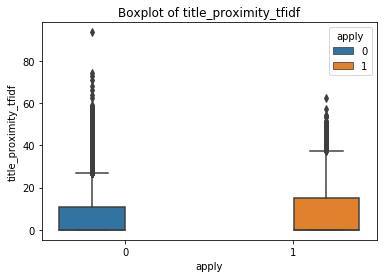

In [17]:
# Data Visualization - BoxPlots
sns.boxplot(data=df, hue='apply', y='title_proximity_tfidf', x='apply')
plt.title('Boxplot of title_proximity_tfidf')

### From the above feature visualization, we can see that only title_proximity_tfidf and main_query_tfidf can give a certain classification. Like, title_proximity_tfidf above around 18 is certainly a Class 1 Apply Label

## Initial Analysis Without Class_ID

In [18]:
df = df.drop(['class_id'], axis = 1)

In [19]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,search_date_pacific,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
0,0.0,0.0,0.000000,0.004824,0.006628,5.0,0,2018-01-21,0,0,0,1,0,0,0
781634,0.0,0.0,2.055071,0.000001,0.000001,13.0,0,2018-01-26,0,0,0,0,1,0,0
781636,NaN,NaN,0.000000,0.018824,0.020905,7.0,0,2018-01-23,0,0,0,1,0,0,0
781639,0.0,0.0,2.004822,0.010279,0.010526,0.0,0,2018-01-27,1,0,0,0,0,0,0
781642,0.0,0.0,2.953156,0.000001,0.000001,3.0,0,2018-01-25,0,0,0,1,0,0,0


In [20]:
df.fillna(df.median(), inplace=True)
df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
count,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06
mean,4.678704e+00,7.873524e-02,1.809905e+00,1.685765e-02,3.469258e-02,1.045177e+01,9.816793e-02,7.822286e-02,1.261641e-01,6.904973e-02,2.775721e-01,4.229523e-01,2.581816e-02,2.206597e-04
std,8.983009e+00,2.592397e-01,2.243628e+00,1.200526e-02,4.743503e-02,1.779251e+01,2.975417e-01,2.685221e-01,3.320344e-01,2.535388e-01,4.478013e-01,4.940282e-01,1.585926e-01,1.485299e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.043647e-02,1.220224e-02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,5.622330e-01,1.562500e-02,2.000000e-02,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.522223e+00,4.530522e-02,3.464677e+00,2.040816e-02,3.655096e-02,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,9.351672e+01,7.301161e+00,1.774189e+01,2.556893e-01,1.294088e+00,1.340000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score']] = scaler.fit_transform(df[['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score']])

In [22]:
# Test-Train Split
df_test = df[df['search_date_pacific']=='2018-01-27']
df_train = df[~df.index.isin(df_test.index)]

Displaying Scatterplots of Features


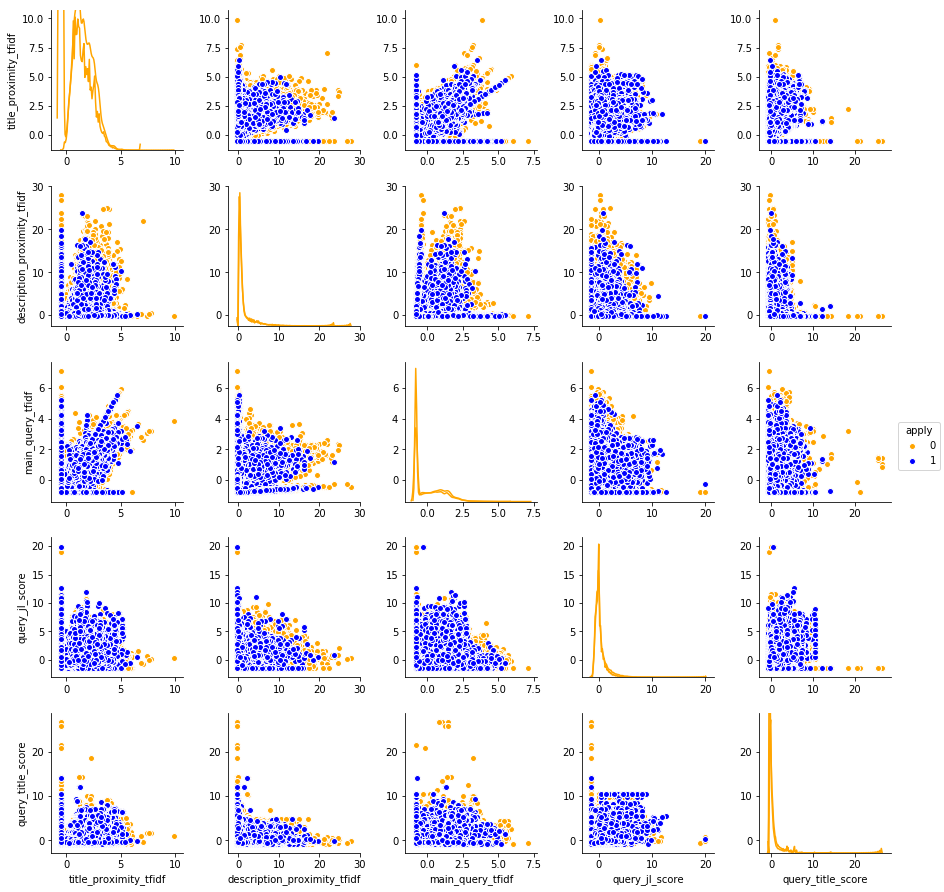

In [23]:
# Data Visualization - Scatterplots
colors = ['orange', 'blue']
print('Displaying Scatterplots of Features')
sns.pairplot(data=df, hue='apply', palette= colors, vars= ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score'], diag_kind='kde')
# plt.title('Displaying Scatterplots of Independent Variables')
warnings.simplefilter("ignore")

In [24]:
df_train.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,search_date_pacific,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
0,-0.52084,-0.303716,-0.806687,-1.002339,-0.591641,5.0,0,2018-01-21,0,0,0,1,0,0,0
781634,-0.52084,-0.303716,0.109272,-1.404106,-0.731350,13.0,0,2018-01-26,0,0,0,0,1,0,0
781636,-0.52084,-0.303716,-0.806687,0.163758,-0.290663,7.0,0,2018-01-23,0,0,0,1,0,0,0
781642,-0.52084,-0.303716,0.509555,-1.404106,-0.731350,3.0,0,2018-01-25,0,0,0,1,0,0,0
781645,-0.52084,-0.125268,0.012998,-0.559029,-0.593857,1.0,0,2018-01-23,0,1,0,0,0,0,0


In [25]:
df_train = df_train.drop(['search_date_pacific', 'job_age_days'], axis = 1)
df_test = df_test.drop(['search_date_pacific', 'job_age_days'], axis = 1)

In [26]:
df_train.groupby('apply').count()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
apply,,,,,,,,,,,,
0,826453,826453,826453,826453,826453,826453,826453,826453,826453,826453,826453,826453
1,89833,89833,89833,89833,89833,89833,89833,89833,89833,89833,89833,89833


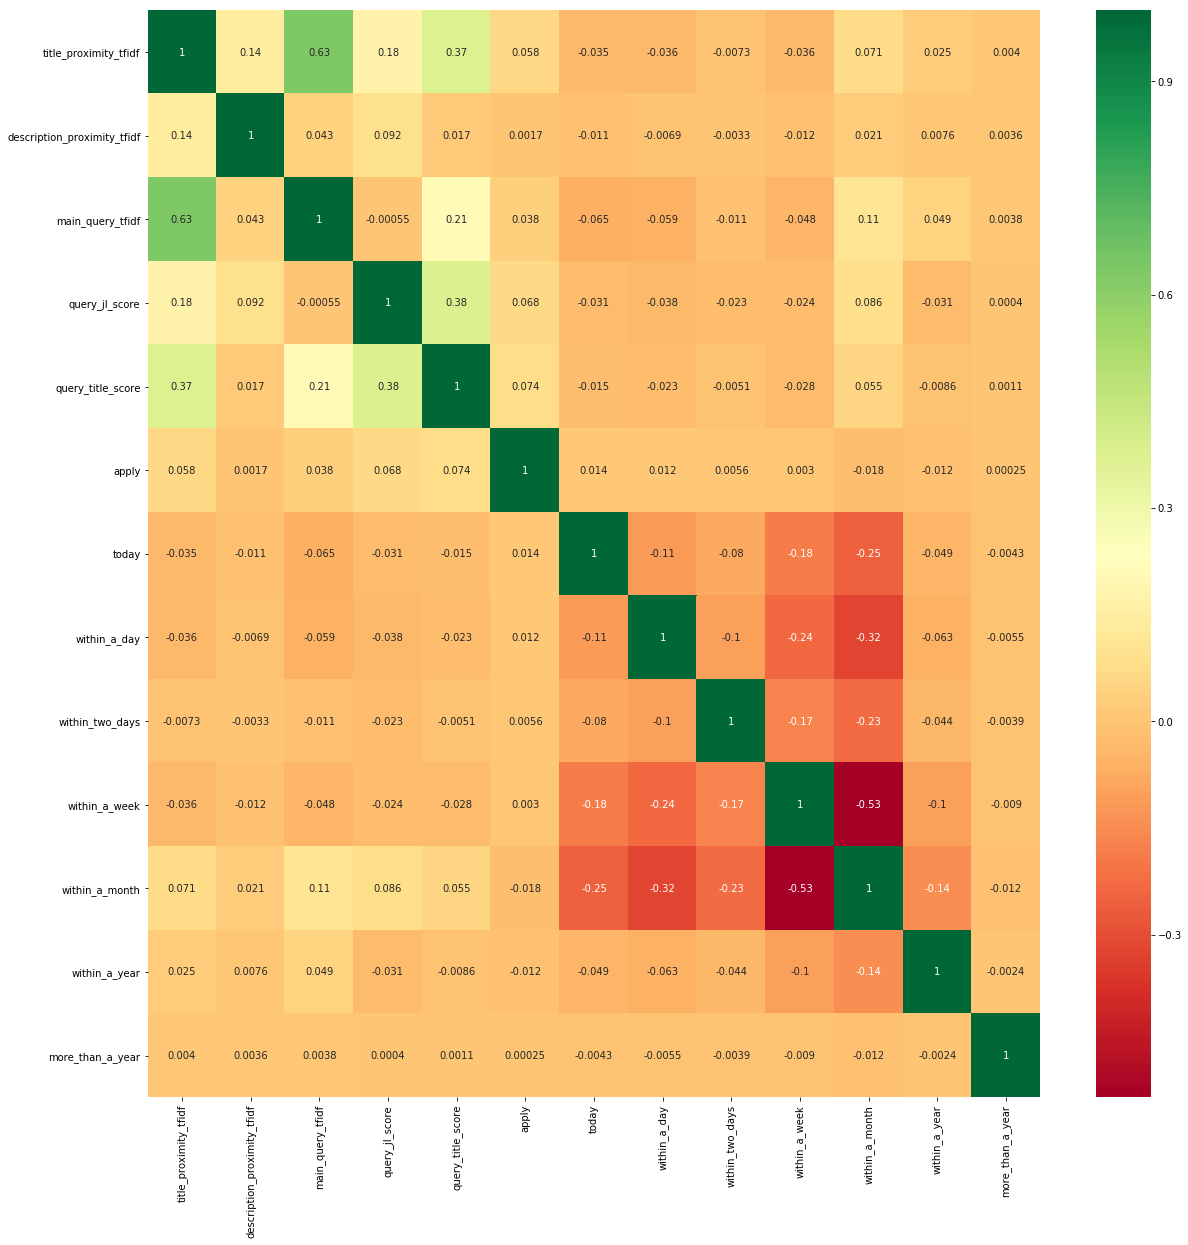

In [27]:
#get correlations of each features in dataset
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

### MODEL ASSESSMENTS WITHOUT CLASS_ID

In [28]:
X_train = df_train.drop('apply', axis=1)
X_test = df_test.drop('apply', axis=1)
y_train = df_train['apply']
y_test = df_test['apply']

### Using Random Undersampling for handling Class imbalance

In [29]:
from imblearn.under_sampling import RandomUnderSampler
rsm = RandomUnderSampler(random_state=42)
X_train, y_train = rsm.fit_sample(X_train, y_train)

### Gradient Bossting Classifier 

      Iter       Train Loss   Remaining Time 
         1           1.3819           39.65s
         2           1.3783           38.26s
         3           1.3754           39.79s
         4           1.3729           37.89s
         5           1.3708           36.68s
         6           1.3688           36.51s
         7           1.3673           36.64s
         8           1.3659           36.71s
         9           1.3647           36.26s
        10           1.3637           35.86s
        20           1.3578           31.02s
        30           1.3551           26.37s
        40           1.3535           21.74s
        50           1.3524           17.76s
        60           1.3514           13.94s
        70           1.3507           10.37s
        80           1.3500            6.89s
        90           1.3495            3.36s
       100           1.3489            0.00s


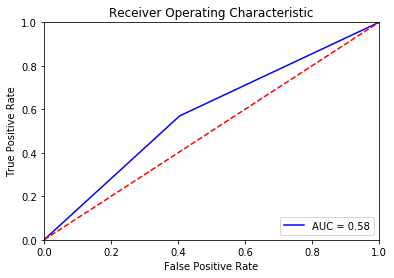

In [30]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
clf = GBC(verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
# Cross-Validation Score on the Training Data for LR
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score 
from sklearn.datasets import make_classification

metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['KFoldStratifiedKFold-CV', 'StratifiedShuffleSplit-CV']) # to store the scores
cv = StratifiedKFold(n_splits=3)
scv = StratifiedShuffleSplit(n_splits=3)
clf = LR(penalty='l1')
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]
    

warnings.simplefilter("ignore")
scores_df

,KFoldStratifiedKFold-CV,StratifiedShuffleSplit-CV
f1,0.51562,0.512986
roc_auc,0.581997,0.583319
average_precision,0.58128,0.579629
accuracy,0.55823,0.561845
precision,0.570629,0.568035
recall,0.470351,0.462449


[LibLinear]0.570844060314


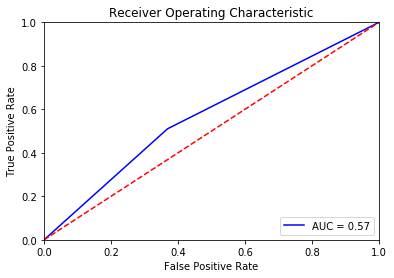

In [36]:
# Performance of LR on Test data

clf = LR(verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

warnings.filterwarnings("ignore", category=FutureWarning)

In [37]:
# Cross-Validation Score on the Training Data for GaussianNB

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score  
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB as GNB

metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['KFoldStratifiedKFold-CV', 'StratifiedShuffleSplit-CV']) # to store the scores
cv = StratifiedKFold(n_splits=3)
scv = StratifiedShuffleSplit(n_splits=3)
clf = GNB()
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]
    

warnings.simplefilter("ignore")
scores_df

,KFoldStratifiedKFold-CV,StratifiedShuffleSplit-CV
f1,0.439962,0.426408
roc_auc,0.573269,0.568234
average_precision,0.572728,0.571136
accuracy,0.54933,0.548524
precision,0.581183,0.577016
recall,0.356583,0.369908


0.564097309835


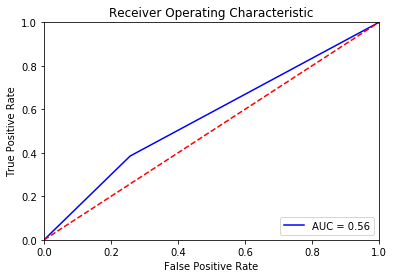

In [38]:
# Performance of GaussianNB on Test data

clf = GNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
# Cross-Validation Score on the Training Data for RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score  
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RFC


metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['KFoldStratifiedKFold-CV', 'StratifiedShuffleSplit-CV']) # to store the scores
cv = StratifiedKFold(n_splits=3)
scv = StratifiedShuffleSplit(n_splits=3)
clf = RFC()
for metric in metric_names:
    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
    scores_df.loc[metric] = [score1, score2]
    

warnings.simplefilter("ignore")
scores_df

,KFoldStratifiedKFold-CV,StratifiedShuffleSplit-CV
f1,0.515208,0.523089
roc_auc,0.563706,0.57244
average_precision,0.54953,0.558252
accuracy,0.545646,0.551641
precision,0.553123,0.558041
recall,0.480547,0.491874


0.541906222059


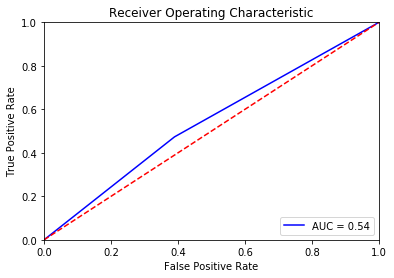

In [40]:
# Performance of RandomForestClassifier on Test data

clf = RFC().fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

warnings.filterwarnings("ignore", category=FutureWarning)

## INCORPORATING CLASS_ID

In [41]:
df = pd.read_csv('Apply_Rate_2019.csv')

In [42]:
df = df.sort_values(by=['apply'])

In [43]:
df = df.drop_duplicates(subset=['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'city_match',
       'job_age_days', 'search_date_pacific', 'class_id'], keep='last')

In [44]:
df = df.drop(['city_match'], axis = 1)

In [45]:
# feature engineering of job_age_days
df['today'] = df.apply(lambda row: 1 * (row['job_age_days'] == 0), axis=1)
df['within_a_day'] = df.apply(lambda row: 1 * (row['job_age_days'] == 1), axis=1)
df['within_two_days'] = df.apply(lambda row: 1 * (row['job_age_days'] == 2), axis=1)
df['within_a_week'] = df.apply(lambda row: 1 * (2 < row['job_age_days'] <= 7), axis=1)
df['within_a_month'] = df.apply(lambda row: 1 * (7 < row['job_age_days'] <= 30), axis=1)
df['within_a_year'] = df.apply(lambda row: 1 * (30 < row['job_age_days'] <= 365), axis=1)
df['more_than_a_year'] = df.apply(lambda row: 1 * (row['job_age_days'] > 365), axis=1)

In [46]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,search_date_pacific,class_id,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
0,0.0,0.0,0.000000,0.004824,0.006628,5.0,0,2018-01-21,-7613806991329176388,0,0,0,1,0,0,0
781634,0.0,0.0,2.055071,0.000001,0.000001,13.0,0,2018-01-26,-4832316967726681842,0,0,0,0,1,0,0
781636,NaN,NaN,0.000000,0.018824,0.020905,7.0,0,2018-01-23,2666095119806832141,0,0,0,1,0,0,0
781639,0.0,0.0,2.004822,0.010279,0.010526,0.0,0,2018-01-27,-7706973126229505444,1,0,0,0,0,0,0
781642,0.0,0.0,2.953156,0.000001,0.000001,3.0,0,2018-01-25,-7867367934152049683,0,0,0,1,0,0,0


In [47]:
df.fillna(df.median(), inplace=True)
df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,class_id,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year
count,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06,1.015138e+06
mean,4.678704e+00,7.873524e-02,1.809905e+00,1.685765e-02,3.469258e-02,1.045177e+01,9.816793e-02,-4.074772e+17,7.822286e-02,1.261641e-01,6.904973e-02,2.775721e-01,4.229523e-01,2.581816e-02,2.206597e-04
std,8.983009e+00,2.592397e-01,2.243628e+00,1.200526e-02,4.743503e-02,1.779251e+01,2.975417e-01,5.653992e+18,2.685221e-01,3.320344e-01,2.535388e-01,4.478013e-01,4.940282e-01,1.585926e-01,1.485299e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,-9.049388e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.043647e-02,1.220224e-02,2.000000e+00,0.000000e+00,-4.593390e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,5.622330e-01,1.562500e-02,2.000000e-02,6.000000e+00,0.000000e+00,-1.614083e+18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.522223e+00,4.530522e-02,3.464677e+00,2.040816e-02,3.655096e-02,1.500000e+01,0.000000e+00,4.315422e+18,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,9.351672e+01,7.301161e+00,1.774189e+01,2.556893e-01,1.294088e+00,1.340000e+03,1.000000e+00,9.204124e+18,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score']] = scaler.fit_transform(df[['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score']])

### FEATURE ENGINEERING FOR CLASS_ID
#### I made two columns for each Class ID counting the number of Apply(Class 1) and Not Apply(Class 0) and incorporate a new Feature Apply Ratio with gives the Number of Apply divided by the total number of Apply + Not Apply. 
This proves to be an important feature as can be seen from the correlation.

In [49]:
# feature engineering of Class_ID 
one = df[df['apply']==1]
zero = df[df['apply']==0]

In [50]:
one_class = one.groupby('class_id').count().sort_values(by=['apply'])
zero_class = zero.groupby('class_id').count().sort_values(by=['apply'])

In [51]:
df['one_apply'] = df.apply(lambda row: one_class['apply'][row['class_id']], axis=1)
df['zero_apply'] = df.apply(lambda row: zero_class['apply'][row['class_id']], axis=1)
df['apply_ratio'] = df.apply(lambda row: one_class['apply'][row['class_id']] / (one_class['apply'][row['class_id']] + zero_class['apply'][row['class_id']]), axis=1)

In [52]:
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,apply,search_date_pacific,class_id,today,within_a_day,within_two_days,within_a_week,within_a_month,within_a_year,more_than_a_year,one_apply,zero_apply,apply_ratio
0,-0.52084,-0.303716,-0.806687,-1.002339,-0.591641,5.0,0,2018-01-21,-7613806991329176388,0,0,0,1,0,0,0,671,12224,0.052036
781634,-0.52084,-0.303716,0.109272,-1.404106,-0.731350,13.0,0,2018-01-26,-4832316967726681842,0,0,0,0,1,0,0,727,8924,0.075329
781636,-0.52084,-0.303716,-0.806687,0.163758,-0.290663,7.0,0,2018-01-23,2666095119806832141,0,0,0,1,0,0,0,255,3355,0.070637
781639,-0.52084,-0.303716,0.086876,-0.547943,-0.509461,0.0,0,2018-01-27,-7706973126229505444,1,0,0,0,0,0,0,576,4979,0.103690
781642,-0.52084,-0.303716,0.509555,-1.404106,-0.731350,3.0,0,2018-01-25,-7867367934152049683,0,0,0,1,0,0,0,413,2869,0.125838


In [53]:
# Test-Train Split
df_test = df[df['search_date_pacific']=='2018-01-27']
df_train = df[~df.index.isin(df_test.index)]

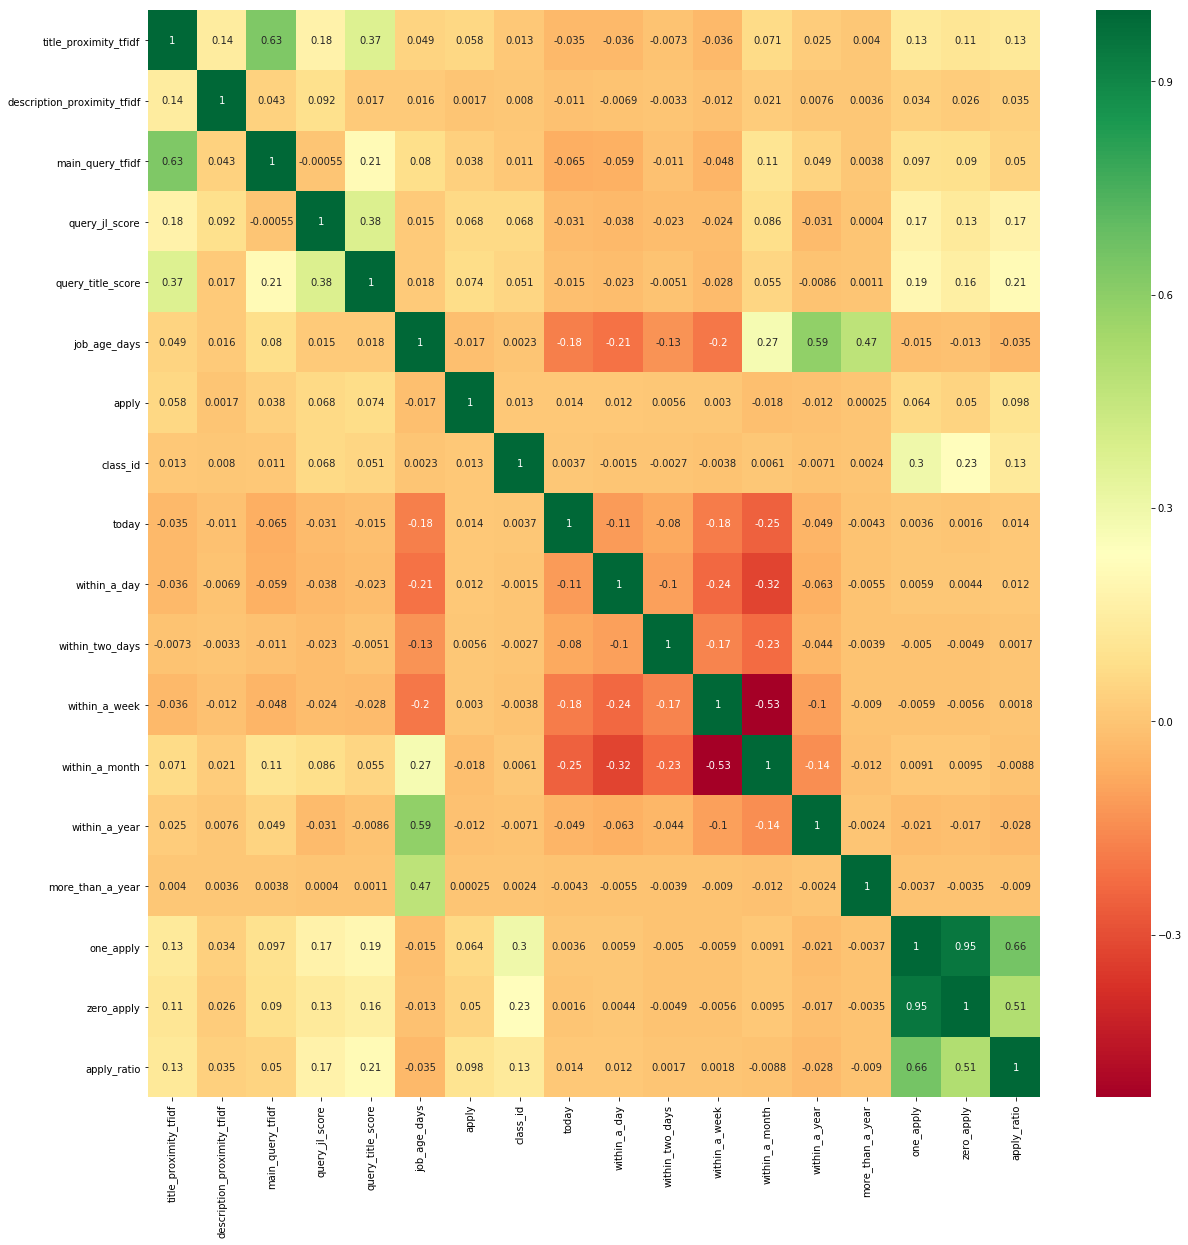

In [54]:
#get correlations of each features in dataset
corrmat = df_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

#### Highest correlation for Apply is given by the newly featured column Apply Ratio. 0.098. Hence, Class-ID is an important feature for the Apply Rate Prediction.

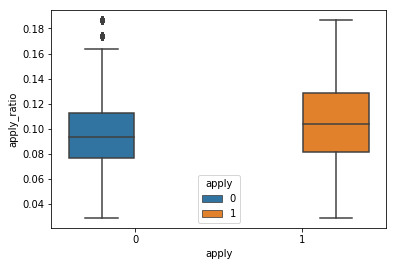

In [55]:
sns.boxplot(data=df_train, hue='apply', y='apply_ratio', x='apply')
plt.show()

#### We can see that for Apply ratio above 0.11, it is definitely in Class 1-Apply, so we get some certain classification.

In [56]:
df_train = df_train.drop(['search_date_pacific', 'job_age_days'], axis=1)
df_test = df_test.drop(['search_date_pacific', 'job_age_days'], axis=1)

In [57]:
X_train = df_train.drop('apply', axis=1)
X_test = df_test.drop('apply', axis=1)
y_train = df_train['apply']
y_test = df_test['apply']

In [58]:
from imblearn.under_sampling import RandomUnderSampler
rsm = RandomUnderSampler(random_state=42)
X_train, y_train = rsm.fit_sample(X_train, y_train)

### Gradient Bossting Classifier 

      Iter       Train Loss   Remaining Time 
         1           1.3794           25.75s
         2           1.3737           25.98s
         3           1.3690           25.87s
         4           1.3652           27.86s
         5           1.3619           27.12s
         6           1.3591           26.49s
         7           1.3568           25.91s
         8           1.3547           26.54s
         9           1.3530           25.89s
        10           1.3514           25.45s
        20           1.3430           22.54s
        30           1.3392           19.69s
        40           1.3371           16.51s
        50           1.3357           13.64s
        60           1.3346           10.96s
        70           1.3338            8.14s
        80           1.3330            5.41s
        90           1.3322            2.72s
       100           1.3315            0.00s


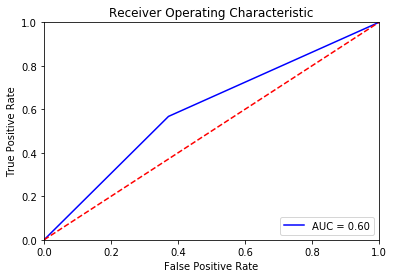

In [59]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
clf = GBC(verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### This is the best AUC score observed: 0.6

[LibLinear]0.513687720031


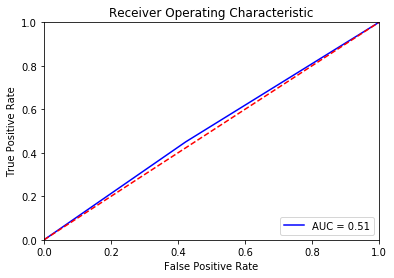

In [60]:
from sklearn.linear_model import LogisticRegression as LR
clf = LR(verbose=1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

warnings.filterwarnings("ignore", category=FutureWarning)

0.516208454733


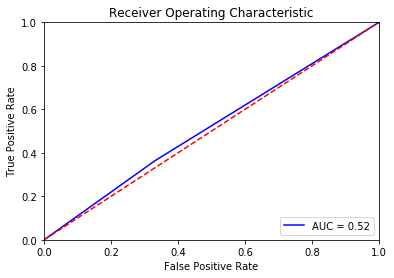

In [61]:
from sklearn.naive_bayes import GaussianNB as GNB
clf = GNB().fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

0.558803807962


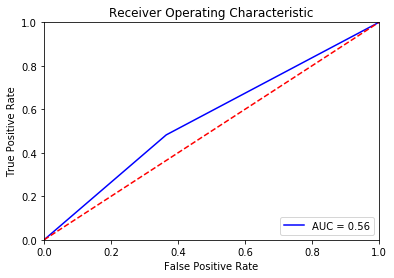

In [62]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf = RFC().fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.score(X_test, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

warnings.filterwarnings("ignore", category=FutureWarning)